In [1]:
%pip install torch torchvision scikit-learn matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
trainset = torchvision.datasets.CIFAR10(
    root = "./data",
    train = True,
    download= True,
    transform = transform
)

testset = torchvision.datasets.CIFAR10(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

train_size = 40000
val_size = 50000 - train_size
generator = torch.Generator().manual_seed(42)
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size], generator= generator)
train_dataloader = DataLoader(
    trainset,
    batch_size = 128,
    shuffle= True,
    num_workers= 2
)
val_dataloader = DataLoader(
    valset,
    batch_size= 128,
    shuffle= False,
    num_workers = 2
)
test_dataloader = DataLoader(
    testset,
    batch_size= 100,
    shuffle = False,
    num_workers= 2
)

print(f"Number of samples in train_set: {len(trainset)}")
print(f"Number of samples in validation_set: {len(valset)}")
print(f"Number of samples in test_set: {len(testset)}")

Number of samples in train_set: 40000
Number of samples in validation_set: 10000
Number of samples in test_set: 10000


In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.1)
    
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
model = MLP()
criterion = nn.CrossEntropyLoss(label_smoothing= 0.1)
optimizer = optim.Adam(model.parameters(), lr = 0.003, weight_decay= 1e-4)   

In [5]:
num_epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_loss = 0
    train_total = 0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    model.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for input_ids, labels in val_dataloader:
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * input_ids.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(val_dataloader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss after Epoch {epoch+1}: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    

Epoch 1, Train Loss: 1.9539, Train Accuracy: 34.16%
Validation Loss after Epoch 1: 1.8206, Validation Accuracy: 40.02%
Epoch 2, Train Loss: 1.8239, Train Accuracy: 40.41%
Validation Loss after Epoch 2: 1.8081, Validation Accuracy: 41.67%
Epoch 3, Train Loss: 1.7895, Train Accuracy: 41.81%
Validation Loss after Epoch 3: 1.7706, Validation Accuracy: 44.05%
Epoch 4, Train Loss: 1.7602, Train Accuracy: 43.29%
Validation Loss after Epoch 4: 1.7368, Validation Accuracy: 44.74%
Epoch 5, Train Loss: 1.7415, Train Accuracy: 44.62%
Validation Loss after Epoch 5: 1.6969, Validation Accuracy: 47.29%
Epoch 6, Train Loss: 1.7167, Train Accuracy: 45.49%
Validation Loss after Epoch 6: 1.7124, Validation Accuracy: 46.09%
Epoch 7, Train Loss: 1.6995, Train Accuracy: 46.55%
Validation Loss after Epoch 7: 1.7108, Validation Accuracy: 46.40%
Epoch 8, Train Loss: 1.6888, Train Accuracy: 47.00%
Validation Loss after Epoch 8: 1.7119, Validation Accuracy: 46.55%
Epoch 9, Train Loss: 1.6724, Train Accuracy: 47.

In [6]:
def test_model(test_dataloader):
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())
    accuracy = 100 * test_correct / test_total
    return accuracy,all_labels, all_preds
accuracy, all_labels, all_preds = test_model(test_dataloader)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 46.4700


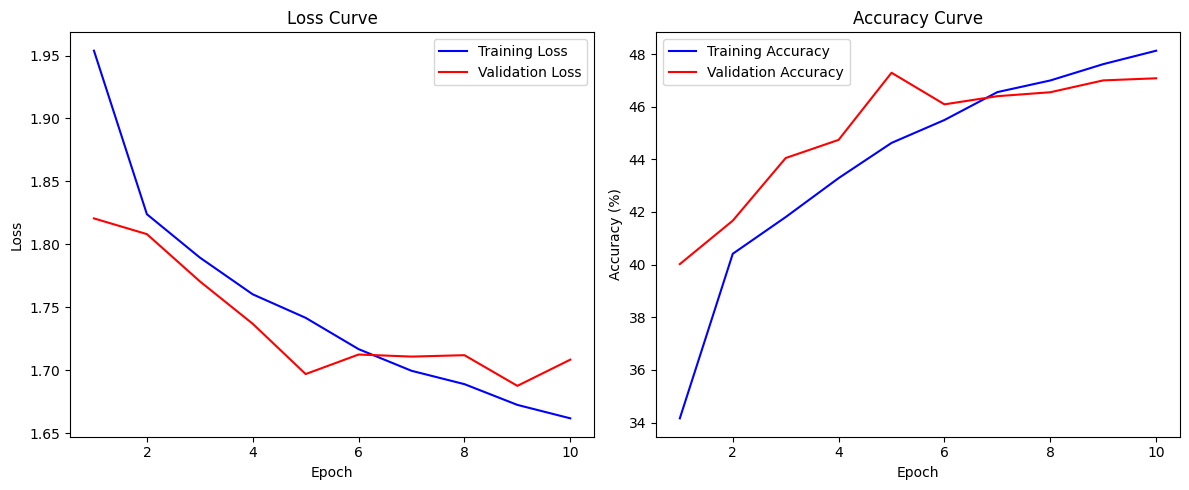

In [7]:
def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies)

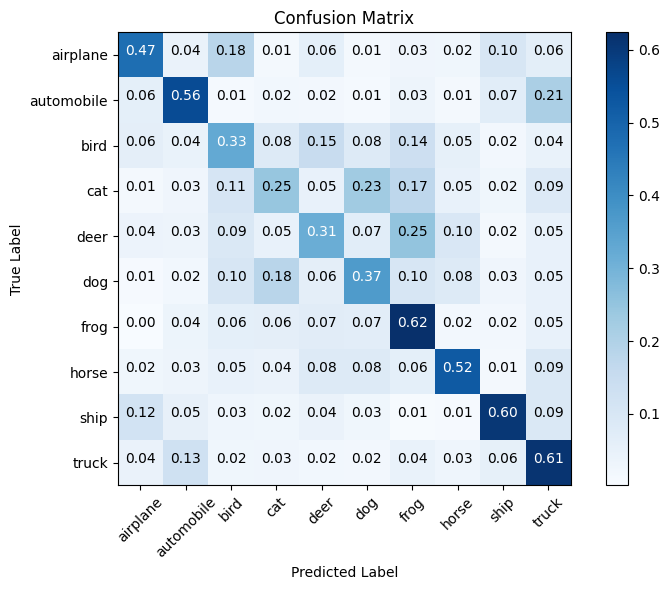

In [8]:
from sklearn.metrics import confusion_matrix
import numpy as np
def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    thresh = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            plt.text(j, i, format(cm_normalized[i, j], '.2f'),
                     horizontalalignment="center",
                     color="white" if cm_normalized[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(all_labels, all_preds, classes= class_names)